Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification-bank-marketing/auto-ml-classification-bank-marketing.png)

# Automated Machine Learning
_**Classification with Deployment using a Bank Marketing Dataset**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Results](#Results)
1. [Deploy](#Deploy)
1. [Test](#Test)
1. [Acknowledgements](#Acknowledgements)

## Introduction

In this example we use the UCI Bank Marketing dataset to showcase how you can use AutoML for a  classification problem and deploy it to an Azure Container Instance (ACI). The classification goal is to predict if the client will subscribe to a term deposit with the bank.

If you are using an Azure Machine Learning Notebook VM, you are all set.  Otherwise, go through the [configuration](../../../configuration.ipynb)  notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Register the model.
6. Create a container image.
7. Create an Azure Container Instance (ACI) service.
8. Test the ACI service.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [3]:
import json
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import datasets
import azureml.dataprep as dprep
from sklearn.model_selection import train_test_split

import azureml.core
#import azureml.widgets
## azure ml SDK Libraries
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

from azureml.train.automl import AutoMLConfig
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
## the config.json file is generated from azure
## and placed in the current directory
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-classification-bmarketing'
# project folder
project_folder = './automl-classification-bankmarketing'

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.48
Subscription ID,7b4cfafc-cbbf-4ac0-bc5d-8f1b8ed831a3
Workspace,bistech-machine-learning
Resource Group,machine-learning
Location,australiaeast
Project Directory,./automl-classification-bankmarketing
Experiment Name,automl-classification-bmarketing


## Create or Attach existing AmlCompute
You will need to create a compute target for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "automlcl"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min_node_count is provided, it will use the scale settings for the cluster.
    compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
    
     # For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.


# Data

Here load the data in the get_data() script to be utilized in azure compute. To do this  first load all the necessary libraries and dependencies to set up paths for the data and to create the conda_Run_config.

In [6]:
if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

In [7]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
import pkg_resources

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to AmlCompute
conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True
conda_run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

dprep_dependency = 'azureml-dataprep==' + pkg_resources.get_distribution("azureml-dataprep").version

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]', dprep_dependency], conda_packages=['numpy','py-xgboost<=0.80'])
conda_run_config.environment.python.conda_dependencies = cd

### Load Data

Here we create the script to be run in azure comput for loading the data, we load the bank marketing dataset into X_train and y_train. Next X_train and y_train is returned for training the model.

We make use of the azureml sdk dprep library.  It does the following tasks
- automatically detect the file type
- Inferr and set the delimiter
- Skipping empty records at the top of the file
- Inerring and setting the header row

In [8]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
dflow = dprep.auto_read_file(data)
dflow.get_profile()
X_train = dflow.drop_columns(columns=['y'])
y_train = dflow.keep_columns(columns=['y'], validate_column_exists=True)
dflow.head()

## purpose of dataset is to predict whether the customer signed up for the term deposit 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.80,92.89,-46.20,1.30,5099.10,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.80,92.89,-46.20,1.31,5099.10,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.40,94.47,-41.80,4.97,5228.10,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
5,58,retired,married,professional.course,no,yes,yes,cellular,jul,fri,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
6,48,services,married,high.school,unknown,yes,no,telephone,may,wed,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
7,51,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,thu,...,7,999,0,nonexistent,1.40,93.44,-36.10,4.96,5228.10,no
8,24,entrepreneur,married,university.degree,no,yes,yes,telephone,jun,wed,...,4,999,0,nonexistent,1.40,94.47,-41.80,4.96,5228.10,no
9,36,technician,divorced,professional.course,no,yes,yes,cellular,jul,mon,...,4,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no


In [9]:
## increase the number of rows displayed in a cell
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

#### Convert to a pandas dataframe to do some preliminary EDA

In [10]:
df_all = dflow.to_pandas_dataframe()

In [9]:
df_all

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,371,1,999,1,failure,-1.80,92.89,-46.20,1.30,5099.10,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,285,2,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,52,1,999,1,failure,-1.80,92.89,-46.20,1.31,5099.10,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,355,4,999,0,nonexistent,1.40,94.47,-41.80,4.97,5228.10,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,189,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
5,58,retired,married,professional.course,no,yes,yes,cellular,jul,fri,605,1,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
6,48,services,married,high.school,unknown,yes,no,telephone,may,wed,243,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
7,51,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,thu,24,7,999,0,nonexistent,1.40,93.44,-36.10,4.96,5228.10,no
8,24,entrepreneur,married,university.degree,no,yes,yes,telephone,jun,wed,126,4,999,0,nonexistent,1.40,94.47,-41.80,4.96,5228.10,no
9,36,technician,divorced,professional.course,no,yes,yes,cellular,jul,mon,43,4,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no


## Some initial EDA

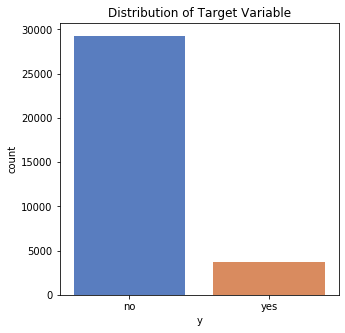

In [11]:

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.countplot(x='y', data=df_all, palette='muted');
plt.title('Distribution of Target Variable');

 The dataset is unbalanced, the yes response has a much smaller amount of values then the no

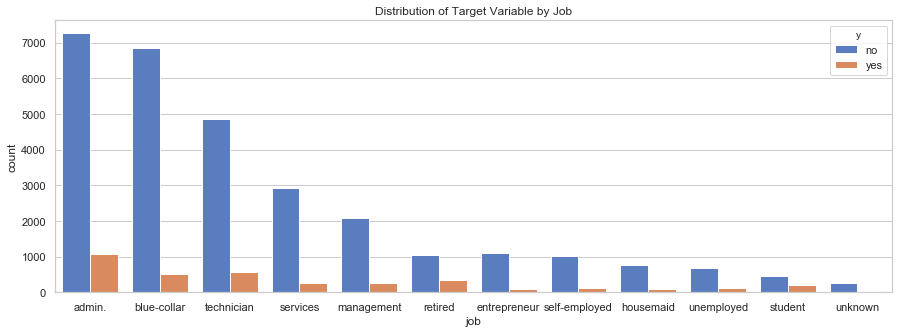

In [12]:
sns.set(style='whitegrid')


fig, ax = plt.subplots()
fig.set_size_inches(15,5)
sns.countplot(x='job',hue='y', data=df_all, palette='muted', order = df_all['job'].value_counts().index)
plt.title('Distribution of Target Variable by Job');


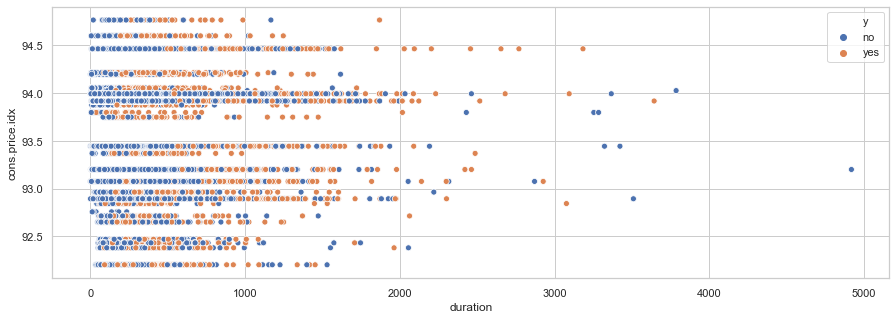

In [13]:
fig, ax = plt.subplots()
df_all['Count'] = 1
fig.set_size_inches(15,5)
sns.scatterplot(x='duration', y = 'cons.price.idx', data=df_all, color='y', hue='y',markers='.');

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], Multi-class targets.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [14]:
automl_settings = {
    "iteration_timeout_minutes": 5,
    "iterations": 20,
    "n_cross_validations": 2,
    "primary_metric": 'AUC_weighted',
    "preprocess": True,
    "max_concurrent_iterations": 5,
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             path = project_folder,
                             #run_configuration=conda_run_config,
                             X = X_train,
                             y = y_train,
                             **automl_settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

Once submitted, the process iterates through different machine learning algorithms and preprocessing settings, adhering to your defined constraints. It chooses the best-fit model by optimizing an accuracy metric.

In [15]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_2cdc78f3-3d18-4277-9d71-41566ddac8a3
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION 

In [17]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-bmarketing,AutoML_2cdc78f3-3d18-4277-9d71-41566ddac8a3,automl,Running,Link to Azure Portal,Link to Documentation


## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [ ]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

It is also possible to view each of the iterations by all of the available metrics

In [18]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items()
               if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AUC_macro,0.94,0.93,0.94,0.89,0.93,0.77,0.93,0.77,0.90,0.94,0.75,0.77,0.94,0.91,0.84,0.92,0.94,0.75,0.94,0.94
AUC_micro,0.94,0.93,0.94,0.89,0.93,0.77,0.93,0.77,0.90,0.94,0.75,0.77,0.94,0.91,0.84,0.92,0.94,0.75,0.94,0.94
AUC_weighted,0.94,0.93,0.94,0.89,0.93,0.77,0.93,0.77,0.90,0.94,0.75,0.77,0.94,0.91,0.84,0.92,0.94,0.75,0.94,0.94
accuracy,0.91,0.88,0.91,0.76,0.90,0.70,0.91,0.71,0.89,0.90,0.80,0.77,0.91,0.90,0.89,0.90,0.89,0.80,0.91,0.90
average_precision_score_macro,0.62,0.57,0.63,0.49,0.57,0.32,0.57,0.33,0.48,0.61,0.39,0.38,0.63,0.51,0.45,0.57,0.63,0.39,0.63,0.63
average_precision_score_micro,0.62,0.57,0.63,0.49,0.57,0.32,0.57,0.33,0.48,0.61,0.39,0.38,0.63,0.51,0.45,0.57,0.63,0.39,0.63,0.63
average_precision_score_weighted,0.62,0.57,0.63,0.49,0.57,0.32,0.57,0.33,0.48,0.61,0.39,0.38,0.63,0.51,0.45,0.57,0.63,0.39,0.63,0.63
balanced_accuracy,0.72,0.84,0.69,0.81,0.63,0.71,0.69,0.71,0.50,0.56,0.70,0.72,0.71,0.59,0.50,0.64,0.51,0.70,0.67,0.59
f1_score_macro,0.74,0.76,0.73,0.65,0.67,0.57,0.72,0.59,0.47,0.58,0.64,0.62,0.74,0.62,0.47,0.67,0.49,0.63,0.71,0.60
f1_score_micro,0.91,0.88,0.91,0.76,0.90,0.70,0.91,0.71,0.89,0.90,0.80,0.77,0.91,0.90,0.89,0.90,0.89,0.80,0.91,0.90


## Deploy

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method on `automl_classifier` returns the best run and the fitted model for the last invocation. Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [19]:
best_run, fitted_model = local_run.get_output()

### Register the Fitted Model for Deployment
If neither `metric` nor `iteration` are specified in the `register_model` call, the iteration with the best primary metric is registered.

In [20]:
description = 'AutoML Model trained on bank marketing data to predict if a client will subscribe to a term deposit'
tags = None
model = local_run.register_model(description = description, tags = tags)

print(local_run.model_id) # This will be written to the script file later in the notebook.

Registering model AutoML2cdc78f33best
AutoML2cdc78f33best


### Create Scoring Script
The scoring script is required to generate the image for deployment. It contains the code to do the predictions on input data.

The web service call uses this script to show how to use the model.

Note the use of the inference_schema libraries.  This is necessary for deployment of model so that Power BI can consume

In [22]:
%%writefile score.py

import pickle
import json
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


## the following methods are required to support consumption of the deployed web service
## from Power BI

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType

def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)
    
    
input_sample = pd.DataFrame(data=[{
                "age": 57,
                "job": "technician",
                "marital": "married",
                "education": "unknown",
                "default": "no",
                "housing": "yes",
                "loan": "yes",
                "contact": "telephone",
                "month": "may",
                "day_of_week": "mon",
                "duration": 234,
                "campaign":3,
                "pdays": 999,
                "previous": 1,
                "poutcome": "failure",
                "emp.var.rate": 1.1,
                "cons.price.idx": 93.444,
                "cons.conf.idx": -46.2,
                "euribor3m": 4.962,
                "nr.employed": 5191
}])
output_sample = np.array([3678.3])

@input_schema('data', PandasParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))

def run(data):
    try:
        result = model.predict(data)
        # you can return any datatype as long as it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Overwriting score.py


### Create a YAML File for the Environment

To ensure the fit results are consistent with the training results, the SDK dependency versions need to be the same as the environment that trains the model. Details about retrieving the versions can be found in notebook [12.auto-ml-retrieve-the-training-sdk-versions](12.auto-ml-retrieve-the-training-sdk-versions.ipynb).

This is an environment file that specifies all of the script's package dependencies. This file is used to make sure that all of those dependencies are installed in the Docker image that the model is deployed to.

In [23]:
experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)

In [24]:
dependencies = ml_run.get_run_sdk_dependencies(iteration = 1)

In [25]:
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.48
azureml-sdk	1.0.48
azureml-core	1.0.48


In [26]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn','py-xgboost<=0.80'],
                                 pip_packages=['azureml-sdk[automl]','inference-schema[numpy-support]','inference-schema[pandas-support]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [27]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

### Create a Container Image

Next use Azure Container Instances for deploying models as a web service for quickly deploying and validating your model
or when testing a model that is under development.

In [28]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "bmData", 'type': "automl_classification"},
                                 description = "Image for automl classification sample")

image = Image.create(name = "automlsampleimage",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running.........................................................
Succeeded
Image creation operation finished for image automlsampleimage:7, operation "Succeeded"


### Deploy the Image as a Web Service on Azure Container Instance

Deploy an image that contains the model and other assets needed by the service.

In [29]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 4, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

In [31]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-sample-bankmarketing'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-bankmarketing
Creating service
Running...........................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


### Delete a Web Service

Deletes the specified web service.

In [ ]:
#aci_service.delete()

### Get Logs from a Deployed Web Service

Gets logs from a deployed web service.

In [ ]:
#aci_service.get_logs()

In [ ]:
print(ws.webservices['automl-sample-bankmarketing'].get_logs())

## Test

Now that the model is trained split our data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [6]:
import requests
import json

headers = {'Content-Type': 'application/json'}

if aci_service.auth_enabled:
    headers['Authorization'] = 'Bearer '+aci_service.get_keys()[0]
elif aci_service.token_auth_enabled:
    headers['Authorization'] = 'Bearer '+aci_service.get_token()[0]

print(headers)

test_sample = json.dumps({'data': [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
]})

response = requests.post(
    aci_service.scoring_uri, data=test_sample, headers=headers)
print(response.status_code)
print(response.elapsed)
print(response.json())

NameError: name 'aci_service' is not defined

In [2]:
# Load the bank marketing datasets.
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from numpy import array

In [3]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_validate.csv"
dflow = dprep.auto_read_file(data)
dflow.get_profile()
X_test = dflow.drop_columns(columns=['y'])
y_test = dflow.keep_columns(columns=['y'], validate_column_exists=True)
dflow.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,25,blue-collar,married,basic.6y,unknown,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
1,58,services,married,high.school,no,yes,no,cellular,jul,fri,...,30,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
2,31,entrepreneur,married,basic.9y,unknown,yes,no,telephone,may,fri,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,30,technician,single,university.degree,unknown,no,no,cellular,aug,tue,...,5,999,0,nonexistent,1.40,93.44,-36.10,4.96,5228.10,no
4,34,admin.,married,university.degree,unknown,unknown,unknown,telephone,jul,wed,...,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
5,35,technician,married,professional.course,no,no,no,telephone,may,tue,...,2,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
6,48,blue-collar,married,basic.4y,no,no,no,telephone,may,tue,...,2,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
7,32,admin.,divorced,high.school,no,no,no,cellular,nov,tue,...,1,999,1,failure,-0.10,93.20,-42.00,4.15,5195.80,no
8,34,technician,divorced,professional.course,no,yes,yes,cellular,apr,fri,...,2,999,1,failure,-1.80,93.08,-47.10,1.41,5099.10,no
9,48,services,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.40,93.44,-36.10,4.97,5228.10,no


In [ ]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [ ]:
y_pred  = fitted_model.predict(X_test)
actual = array(y_test)
actual = actual[:,0]
print(y_pred.shape, " ", actual.shape)

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

In [ ]:
%matplotlib notebook
test_pred = plt.scatter(actual, y_pred, color='b')
test_test = plt.scatter(actual, actual, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

## Acknowledgements

This Bank Marketing dataset is made available under the Creative Commons (CCO: Public Domain) License: https://creativecommons.org/publicdomain/zero/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: https://creativecommons.org/publicdomain/zero/1.0/ and is available at: https://www.kaggle.com/janiobachmann/bank-marketing-dataset .

_**Acknowledgements**_
This data set is originally available within the UCI Machine Learning Database: https://archive.ics.uci.edu/ml/datasets/bank+marketing

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014